In [133]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
    
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [134]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

/tmp/ipykernel_30115/3631382287.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [135]:
%load_ext autoreload
%autoreload 2
import os
import cooler
import cooltools
import numpy as np
from cooltools.api import eigdecomp
import bioframe
from pathlib import Path
import multiprocess as mp

from copy import copy

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from supp_lib import *
# import all samples as dictionary ...
from samples import *

### some of the input cooler files that we used to combine/recombine/subset etc

In [137]:
ins_samples = {
    "Hap1-WT-combined.hg19" : "Hap1-WT-combined.mcool",
    "PolII-IAA.hg19" : "PolII-IAA.hg19.mapq_30.1000.mcool",
    "PolII-NT.hg19" : "PolII-NT.hg19.mapq_30.1000.mcool",
    "all_CTCF_combined.hg19" : "all_combined.mcool",
    "noCTCF_IAA_combined.hg19" : "noCTCF_IAA_combined.mcool",
    
    "all_CTCF_combined.hg19" : "all_combined.mcool",
    "noCTCF_IAA_combined.hg19" : "noCTCF_IAA_combined.mcool",
    
    "CkoCT442_NT_pool.hg19" : "CkoCT442-NT-pool.mcool",
    "CkoCT442_IAA_pool.hg19" : "CkoCT442-IAA-pool.mcool",
    # RAD21 degron for HCT from Rao et al 2017 ...
    "RAD21-IAA.hg19" : "RAD21-AID-IAA-6H.hg19.mapq_30.1000.mcool",
    "RAD21-NT.hg19" : "RAD21-AID-NT.hg19.mapq_30.1000.mcool",

    # WAPL KO for HAP1 from Haarhuis 2017 ...
    "WAPL-KO1.hg19" : "Haarthuis-WAPL-KO1.14.hg19.mapq_30.1000.mcool",
    "WAPL-KO3.hg19" : "Haarthuis-WAPL-KO3.3.hg19.mapq_30.1000.mcool",
    "WAPL-WT.hg19" : "Haarthuis-HAP1-WT.hg19.mapq_30.1000.mcool",

    "CkoC442-IAA48H-R1-T1.hg19" : "CkoC442-IAA48H-R1-T1__hg19.hg19.mapq_30.1000.mcool",
    "CkoC442-NT-R1-T1.hg19" : "./wt_like_coolers_to_combine/CkoC442-NT-R1-T1__hg19.hg19.mapq_30.1000.mcool",
    "CkoCT442-AAVS1sg2-4-NT-R1-T1.hg19" : "CkoCT442-AAVS1sg2-4-NT-R1-T1__hg19.hg19.mapq_30.1000.mcool",
    "CkoCT442-DDX55sg2-B-NT-R1-T1.hg19" : "CkoCT442-DDX55sg2-B-NT-R1-T1__hg19.hg19.mapq_30.1000.mcool",
    "G1-NT.hg19" : "G1-NT.hg19.1kb.mcool",
    "G1-IAA.hg19" : "G1-IAA.hg19.1kb.mcool",
    
    # Mutants time !!!
    # Knock-outs - genes were deleted ...
    "mutControl-NT.hg19":"CkoCT442-AAVS1-NT-pool.mcool",
    "mutControl-IAA.hg19":"CkoCT442-AAVS1-IAA-pool.mcool",
    "mutDDX55-NT.hg19":"DDX55-clones-NT.hg19.mapq_30.1000.mcool",
    "mutDDX55-IAA.hg19":"DDX55-clones-IAA.hg19.mapq_30.1000.mcool",
    "mutTAF5L-NT.hg19":"TAF5L-clones-NT.hg19.mapq_30.1000.mcool",
    "mutTAF5L-IAA.hg19":"TAF5L-clones-IAA.hg19.mapq_30.1000.mcool",
    # Knock-downs - genes were silenced/deplted (siRNA) ...
    "siControl-NT.hg19":"siCTRL-NT.hg19.mapq_30.1000.mcool",
    "siControl-IAA.hg19":"siCTRL-IAA.hg19.mapq_30.1000.mcool",
    "siDDX55-NT.hg19":"siDDX55-NT.hg19.mapq_30.1000.mcool",
    "siDDX55-IAA.hg19":"siDDX55-IAA.hg19.mapq_30.1000.mcool",
    "siTAF5L-NT.hg19":"siTAF5L-NT.hg19.mapq_30.1000.mcool",
    "siTAF5L-IAA.hg19":"siTAF5L-IAA.hg19.mapq_30.1000.mcool",
    
    # PlaB (splicing inhibition) two replicates pooled together - known to affect R-loops (mostly destabilize)
    "CtrlPlaB-NT.hg19" : "NT-hg19-combined-90000000.mcool",
    "CtrlPlaB-IAA.hg19" : "IAA-hg19-combined-90000000.mcool",
    "PlaB-NT.hg19" : "NT-PlaB-hg19-combined-90000000.mcool",
    "PlaB-IAA.hg19" : "IAA-PlaB-hg19-combined-90000000.mcool",
    
    ## Pool HAP1 WT, NO TIR1 and TIR1
    # this is a special subsampling case for the standard CTCF-degron(+aux)
    # but normalized, such that the number of reads, matches the NO-TIR1
    "Ctrl500M-noTIR1.hg19" : "CkoC44-NO-TIR1-pool.mcool",
    "Ctrl500M-wtHAP1.hg19" : "Hap1-WT-combined-500000000.mcool",
    "Ctrl500M-CT442-NT.hg19" : "CkoCT442-NT-pool-500000000.mcool",
    "Ctrl500M-CT442-IAA.hg19" : "CkoCT442-IAA-pool-500000000.mcool",
    
    ## A group for comparing PolII degron samples - i.e. with matched read depth to Hap1WT
    # "Hap1-WT-combined.hg19" : "Hap1-WT-combined.mcool",
    "PolII-800M-IAA.hg19" : "PTB2539-IAA-pool-800000000.mcool",
    "PolII-800M-NT.hg19" : "PTB2539-NT-pool-800000000.mcool",
}


In [138]:
# to plot ticks in terms of megabases we use the EngFormatter 
# https://matplotlib.org/gallery/api/engineering_formatter.html
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)


In [139]:
from matplotlib import colors
from cooltools.lib import numutils
from mpl_toolkits.axes_grid import make_axes_locatable

In [140]:
import scipy
def rotate_hm(hm):
    # fill NaNs with 1.0 (obs==exp), otherwise flipping 45 breaks ...
    hm = np.nan_to_num(hm, nan=0.)
    _hm = scipy.ndimage.rotate(hm,45,cval=np.nan,reshape=True)
    l,w = _hm.shape
    half_l = l//2
    # removing upper pic spitz vershina "verh == up"
    pic_hide = int(0.33*half_l)
    return _hm[pic_hide:half_l,:]

def gene_track_to_intervals(track):
    if (track > 0.8).any() and len(track):
        # define diff track to find start,end locations
        diff_track = np.diff(track)
        starts = np.argwhere(diff_track>0.8).flatten()
        ends = np.argwhere(diff_track<-0.8).flatten()

        # add 0 or the end to starts or ends if needed
        if len(starts):
            if starts[0] > ends[0]:
                # add 0 as a start, it the first start if missing
                starts = np.r_[0, starts]
        else:
            starts = np.array([0])
        if len(ends):
            if ends[-1] < starts[-1]:
                # add 0 as a start, it the first start if missing
                ends = np.r_[ends, len(track)-1]
        else:
            end = np.array(len(track)-1)
        # return
        return starts, ends
    else:
        return [], []


In [ ]:
# "ctcf","noctcf",

# "rad21_CTCF","rad21_noCTCF",
# "rad21_CTCF_r2","rad21_noCTCF_r2",

# "ddx_CTCF","ddx_noCTCF",
# "ddx_CTCF_r2","ddx_noCTCF_r2",

# "taf5l_CTCF","taf5l_noCTCF",
# "taf5l_CTCF_r2","taf5l_noCTCF_r2",

# "mrna_ctcf"

In [101]:
regions = []
regions.append("chr1:153,405,956-153,605,104")
regions.append("chr1:154,989,365-155,097,507")
regions.append("chr1:155,136,106-155,200,956")
regions.append("chr3:32,172,573-32,362,161")
regions.append("chr3:39,304,235-39,561,708")

#DDX55 peak that decrease at promoter
regions.append("chr1:153,563,139-153,762,287")
regions.append("chr1:204,462,984-204,484,028")
regions.append("chr3:45,624,263-45,822,933")

#RAD21 stays after CTCF depletion and DDX55 peak
regions.append("chr1:160,289,004-160,340,467")
regions.append("chr1:173,670,619-173,695,654")

#TAF5L and RAD21 at promoter
regions.append("chr1:163,259,163-163,334,271")
regions.append("chr1:184,000,318-184,054,215")
regions.append("chr3:12,480,619-12,730,220")
regions.append("chr3:53,344,268-53,434,328")
regions.append("chr3:149,451,099-149,487,431")

#TAF5L at promoter that decrease
regions.append("chr1:180,456,164-180,508,496")

#example of a TAF5L peak that decrease
regions.append("chr1:151,649,232-151,734,945")


original length of the region chr1:155,136,106-155,200,956 is 64kb
pulling ctcf ...
pulling noctcf ...
pulling rad21_CTCF ...
pulling rad21_noCTCF ...
pulling ddx_CTCF ...
pulling ddx_noCTCF ...
pulling taf5l_CTCF ...
pulling taf5l_noCTCF ...
pulling mrna_ctcf ...
(1.0, 550.0)


/tmp/ipykernel_30115/2146739117.py:133: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  cax.arrow(s,1+.1,e-s,0,width=0.05, head_width=0.05, head_length=5, edgecolor="none",color="red");
/tmp/ipykernel_30115/2146739117.py:136: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  cax.arrow(e,1-.1,s-e,0,width=0.05, head_width=0.05, head_length=5, edgecolor="none",color="blue");
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 31 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.nu

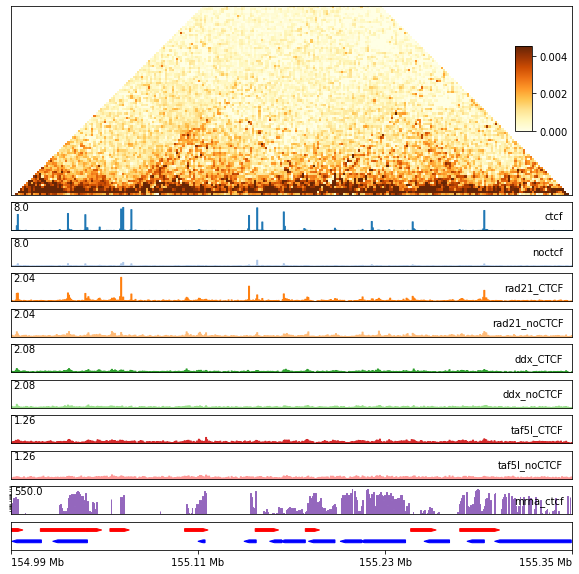

In [156]:
region = regions[2]

chrom, start, end = bioframe.parse_region_string(region)
print(f"original length of the region {region} is {int((end - start)/1000)}kb")
start -= 150_000
end += 150_000

binsize = 2000
clr = cooler.Cooler(f"""{ins_samples["CkoCT442_NT_pool.hg19"]}::/resolutions/{binsize}""")
mat = clr.matrix().fetch((chrom,start,end))
clr_width, = np.diff(clr.extent((chrom,start,end)))
# ignore 2 diagonals ...
for diag in [-1,0,1]:
    mat = numutils.set_diag(mat, np.nan, diag, copy=True)

fig_samples = ["ctcf","noctcf","rad21_CTCF","rad21_noCTCF","ddx_CTCF","ddx_noCTCF","taf5l_CTCF","taf5l_noCTCF","mrna_ctcf"]
vecs = {}
for s in fig_samples:
    print(f"pulling {s} ...")
    v = bbi.fetch(
        samples[s]["fname"],
        chrom=chrom,
        start=start,
        end=end,
        bins=3*clr_width,
        missing=0.0,
        oob=np.nan,
        summary='mean',
    )
    vecs[s] = v

genp = bbi.fetch(
    "gene_plus.bb",
    chrom=chrom,
    start=start,
    end=end,
    bins=3*clr_width,
    missing=0.0,
    oob=np.nan,
    summary='mean',
)

genm = bbi.fetch(
    "gene_minus.bb",
    chrom=chrom,
    start=start,
    end=end,
    bins=3*clr_width,
    missing=0.0,
    oob=np.nan,
    summary='mean',
)

f,ax = plt.subplots(figsize=(20,10))

matt = ax.imshow(
    rotate_hm(mat),
    norm=colors.Normalize(vmin=0.0000,vmax=0.0045),
#     norm=colors.LogNorm(vmin=0.0001,vmax=0.008),
    cmap="YlOrBr",
    interpolation="none",
)
ax.set_xticks([])
ax.set_yticks([])
cbaxes = inset_axes(ax, width="3%", height="45%", loc="upper right", borderpad=4)
cbaxes.tick_params(axis="y",direction="out")
plt.colorbar(matt, cax=cbaxes, orientation='vertical')



divider = make_axes_locatable(ax)

wtid=0 # a counter for the color of the chip-tracks
cmap = plt.cm.tab20 # color set ...
for s,track in vecs.items():
    cax = divider.append_axes("bottom", size="15%", pad=0.1)
    cax.set_xlim(0,3*clr_width)
    if s in ["ctcf","noctcf"]:
        s_color="tab:blue"
        s_color=cmap(0 + (wtid%2)/20.)
    elif s in ["rad21_CTCF","rad21_noCTCF"]:
        s_color="tab:red"
        s_color=cmap(1/10. + (wtid%2)/20.)
    elif s in ["ddx_CTCF","ddx_noCTCF"]:
        s_color="tab:cyan"
        s_color=cmap(2/10. + (wtid%2)/20.)
    elif s in ["taf5l_CTCF","taf5l_noCTCF"]:
        s_color="tab:olive"
        s_color=cmap(3/10. + (wtid%2)/20.)
    elif s in ["mrna_ctcf",]:
        s_color="green"
        s_color=cmap(4/10. + (wtid%2)/20.)
    else:
        cax.set_ylim(ymin, ymax)
    wtid += 1
    if s in ["mrna_ctcf",]:
        cax.fill_between(x=np.arange(len(track)), y1=track, y2=1, where=(track>=1.0), step="post",label=s, color=s_color)
    else:
        cax.fill_between(x=np.arange(len(track)), y1=track, y2=0, step="post",label=s, color=s_color)
    cax.set_xticks([])
    leg = cax.legend(frameon=False, handlelength=0.0,handletextpad=-2.0)
    for item in leg.legendHandles:
        item.set_visible(False)
    ymin, ymax = samples[s]["crange"]
    # control limits manually on track to track basis:
    if s in ["ctcf","noctcf"]:
        ymax = 2.5*ymax
    elif s in ["rad21_CTCF","rad21_noCTCF"]:
        ymax = 4*ymax
    elif s in ["ddx_CTCF","ddx_noCTCF"]:
        ymax = 4*ymax
    elif s in ["taf5l_CTCF","taf5l_noCTCF"]:
        ymax = 6*ymax
    elif s in ["mrna_ctcf",]:
        ymax = 25*ymax
    else:
        pass
    if samples[s]["norm"] is not None:
        cax.set_yscale("log")
        ymin = 1
    cax.set_ylim(ymin, ymax)
    cax.set_yticks([ymax])
    cax.set_yticklabels([ymax], va='top', ha="left",minor=False)
    cax.tick_params(axis="y",direction="in",pad=-3)    
print(cax.get_ylim())

cax = divider.append_axes("bottom", size="15%", pad=0.1)
cax.set_xlim(0,3*clr_width)


for s,e in zip(*gene_track_to_intervals(genp)):
    if e-s>1:
        cax.arrow(s,1+.1,e-s,0,width=0.05, head_width=0.05, head_length=5, edgecolor="none",color="red");
for s,e in zip(*gene_track_to_intervals(genm)):
    if e-s>1:
        cax.arrow(e,1-.1,s-e,0,width=0.05, head_width=0.05, head_length=5, edgecolor="none",color="blue");
cax.set_ylim(1-0.25,1+0.25)
cax.set_yticks([])


xticks = np.linspace(0,3*clr_width,4)
cax.set_xticks(xticks)

def nice_bp(bp):
    if bp > 1_000_000:
        return f"{(bp/1_000_000):.2f} Mb"
    elif bp > 1_000:
        return f"{(bp/1_000):.2f} kb"
    else:
        return f"{int(bp)} b"


cax.set_xticklabels(
    [
        nice_bp((clr.offset((chrom,start,end)) + (xt/3.0))*clr.binsize) for xt in xticks
    ],
    ha="left",
)

for ii,label in enumerate(cax.xaxis.get_majorticklabels()):
    if ii==0:
        label.set_ha("left")
    elif ii<3:
        label.set_ha("center")
    else:
        label.set_ha("right")

plt.savefig(f"latest_greates1.pdf")


original length of the region chr1:153,563,139-153,762,287 is 199kb
pulling ctcf ...
pulling noctcf ...
pulling rad21_CTCF ...
pulling rad21_noCTCF ...
pulling ddx_CTCF ...
pulling ddx_noCTCF ...
pulling taf5l_CTCF ...
pulling taf5l_noCTCF ...
pulling mrna_ctcf ...
(1.0, 1100.0)


/tmp/ipykernel_30115/2599956744.py:130: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  cax.arrow(s,1+.1,e-s,0,width=0.05, head_width=0.05, head_length=5, edgecolor="none",color="red");
/tmp/ipykernel_30115/2599956744.py:133: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  cax.arrow(e,1-.1,s-e,0,width=0.05, head_width=0.05, head_length=5, edgecolor="none",color="blue");
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 32 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.nu

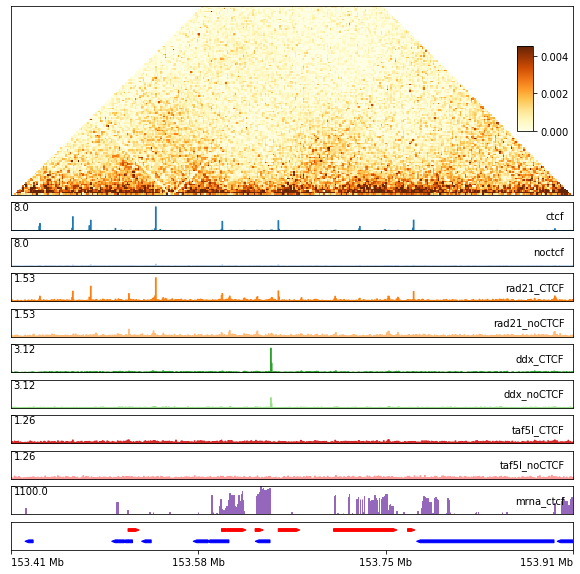

In [157]:
region = regions[5]

chrom, start, end = bioframe.parse_region_string(region)
print(f"original length of the region {region} is {int((end - start)/1000)}kb")
start -= 150_000
end += 150_000

binsize = 2000
clr = cooler.Cooler(f"""{ins_samples["CkoCT442_NT_pool.hg19"]}::/resolutions/{binsize}""")
mat = clr.matrix().fetch((chrom,start,end))
clr_width, = np.diff(clr.extent((chrom,start,end)))
# ignore 2 diagonals ...
for diag in [-1,0,1]:
    mat = numutils.set_diag(mat, np.nan, diag, copy=True)

fig_samples = ["ctcf","noctcf","rad21_CTCF","rad21_noCTCF","ddx_CTCF","ddx_noCTCF","taf5l_CTCF","taf5l_noCTCF","mrna_ctcf"]
vecs = {}
for s in fig_samples:
    print(f"pulling {s} ...")
    v = bbi.fetch(
        samples[s]["fname"],
        chrom=chrom,
        start=start,
        end=end,
        bins=3*clr_width,
        missing=0.0,
        oob=np.nan,
        summary='mean',
    )
    vecs[s] = v

genp = bbi.fetch(
    "gene_plus.bb",
    chrom=chrom,
    start=start,
    end=end,
    bins=3*clr_width,
    missing=0.0,
    oob=np.nan,
    summary='mean',
)

genm = bbi.fetch(
    "gene_minus.bb",
    chrom=chrom,
    start=start,
    end=end,
    bins=3*clr_width,
    missing=0.0,
    oob=np.nan,
    summary='mean',
)

f,ax = plt.subplots(figsize=(19,10))

matt = ax.imshow(
    rotate_hm(mat),
    norm=colors.Normalize(vmin=0.0000,vmax=0.0045),
#     norm=colors.LogNorm(vmin=0.0001,vmax=0.008),
    cmap="YlOrBr",
    interpolation="none",
)
ax.set_xticks([])
ax.set_yticks([])
cbaxes = inset_axes(ax, width="3%", height="45%", loc="upper right", borderpad=4)
cbaxes.tick_params(axis="y",direction="out")
plt.colorbar(matt, cax=cbaxes, orientation='vertical')

divider = make_axes_locatable(ax)

wtid=0 # a counter for the color of the chip-tracks
cmap = plt.cm.tab20 # color set ...
for s,track in vecs.items():
    cax = divider.append_axes("bottom", size="15%", pad=0.1)
    cax.set_xlim(0,3*clr_width)
    if s in ["ctcf","noctcf"]:
        s_color="tab:blue"
        s_color=cmap(0 + (wtid%2)/20.)
    elif s in ["rad21_CTCF","rad21_noCTCF"]:
        s_color="tab:red"
        s_color=cmap(1/10. + (wtid%2)/20.)
    elif s in ["ddx_CTCF","ddx_noCTCF"]:
        s_color="tab:cyan"
        s_color=cmap(2/10. + (wtid%2)/20.)
    elif s in ["taf5l_CTCF","taf5l_noCTCF"]:
        s_color="tab:olive"
        s_color=cmap(3/10. + (wtid%2)/20.)
    elif s in ["mrna_ctcf",]:
        s_color="green"
        s_color=cmap(4/10. + (wtid%2)/20.)
    else:
        cax.set_ylim(ymin, ymax)
    wtid += 1
    if s in ["mrna_ctcf",]:
        cax.fill_between(x=np.arange(len(track)), y1=track, y2=1, where=(track>=1.0), step="post",label=s, color=s_color)
    else:
        cax.fill_between(x=np.arange(len(track)), y1=track, y2=0, step="post",label=s, color=s_color)
    cax.set_xticks([])
    leg = cax.legend(frameon=False, handlelength=0.0,handletextpad=-2.0)
    for item in leg.legendHandles:
        item.set_visible(False)
    ymin, ymax = samples[s]["crange"]
    # control limits manually on track to track basis:
    if s in ["ctcf","noctcf"]:
        ymax = 2.5*ymax
    elif s in ["rad21_CTCF","rad21_noCTCF"]:
        ymax = 3*ymax
    elif s in ["ddx_CTCF","ddx_noCTCF"]:
        ymax = 6*ymax
    elif s in ["taf5l_CTCF","taf5l_noCTCF"]:
        ymax = 6*ymax
    elif s in ["mrna_ctcf",]:
        ymax = 50*ymax
    else:
        pass
    if samples[s]["norm"] is not None:
        cax.set_yscale("log")
        ymin = 1
    cax.set_ylim(ymin, ymax)
    cax.set_yticks([ymax])
    cax.set_yticklabels([ymax], va='top', ha="left",minor=False)
    cax.tick_params(axis="y",direction="in",pad=-3)    
print(cax.get_ylim())

cax = divider.append_axes("bottom", size="15%", pad=0.1)
cax.set_xlim(0,3*clr_width)

for s,e in zip(*gene_track_to_intervals(genp)):
    if e-s>1:
        cax.arrow(s,1+.1,e-s,0,width=0.05, head_width=0.05, head_length=5, edgecolor="none",color="red");
for s,e in zip(*gene_track_to_intervals(genm)):
    if e-s>1:
        cax.arrow(e,1-.1,s-e,0,width=0.05, head_width=0.05, head_length=5, edgecolor="none",color="blue");
cax.set_ylim(1-0.25,1+0.25)
cax.set_yticks([])


xticks = np.linspace(0,3*clr_width,4)
cax.set_xticks(xticks)

def nice_bp(bp):
    if bp > 1_000_000:
        return f"{(bp/1_000_000):.2f} Mb"
    elif bp > 1_000:
        return f"{(bp/1_000):.2f} kb"
    else:
        return f"{int(bp)} b"


cax.set_xticklabels(
    [
        nice_bp((clr.offset((chrom,start,end)) + (xt/3.0))*clr.binsize) for xt in xticks
    ],
    ha="left",
)

for ii,label in enumerate(cax.xaxis.get_majorticklabels()):
    if ii==0:
        label.set_ha("left")
    elif ii<3:
        label.set_ha("center")
    else:
        label.set_ha("right")

plt.savefig(f"latest_greates2.pdf")


original length of the region chr1:163,259,163-163,334,271 is 75kb
pulling ctcf ...
pulling noctcf ...
pulling rad21_CTCF ...
pulling rad21_noCTCF ...
pulling ddx_CTCF ...
pulling ddx_noCTCF ...
pulling taf5l_CTCF ...
pulling taf5l_noCTCF ...
pulling mrna_ctcf ...
(1.0, 550.0)


/tmp/ipykernel_30115/2674404424.py:130: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  cax.arrow(s,1+.1,e-s,0,width=0.05, head_width=0.05, head_length=5, edgecolor="none",color="red");
/tmp/ipykernel_30115/2674404424.py:133: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  cax.arrow(e,1-.1,s-e,0,width=0.05, head_width=0.05, head_length=5, edgecolor="none",color="blue");
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 31 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.nu

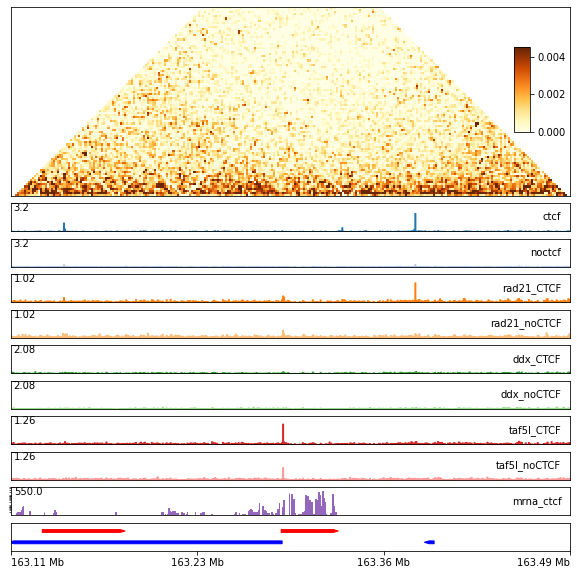

In [158]:
region = regions[10]

chrom, start, end = bioframe.parse_region_string(region)
print(f"original length of the region {region} is {int((end - start)/1000)}kb")
start -= 150_000
end += 150_000

binsize = 2000
clr = cooler.Cooler(f"""{ins_samples["CkoCT442_NT_pool.hg19"]}::/resolutions/{binsize}""")
mat = clr.matrix().fetch((chrom,start,end))
clr_width, = np.diff(clr.extent((chrom,start,end)))
# ignore 2 diagonals ...
for diag in [-1,0,1]:
    mat = numutils.set_diag(mat, np.nan, diag, copy=True)

fig_samples = ["ctcf","noctcf","rad21_CTCF","rad21_noCTCF","ddx_CTCF","ddx_noCTCF","taf5l_CTCF","taf5l_noCTCF","mrna_ctcf"]
vecs = {}
for s in fig_samples:
    print(f"pulling {s} ...")
    v = bbi.fetch(
        samples[s]["fname"],
        chrom=chrom,
        start=start,
        end=end,
        bins=3*clr_width,
        missing=0.0,
        oob=np.nan,
        summary='mean',
    )
    vecs[s] = v

genp = bbi.fetch(
    "gene_plus.bb",
    chrom=chrom,
    start=start,
    end=end,
    bins=3*clr_width,
    missing=0.0,
    oob=np.nan,
    summary='mean',
)

genm = bbi.fetch(
    "gene_minus.bb",
    chrom=chrom,
    start=start,
    end=end,
    bins=3*clr_width,
    missing=0.0,
    oob=np.nan,
    summary='mean',
)

f,ax = plt.subplots(figsize=(19,10))

matt = ax.imshow(
    rotate_hm(mat),
    norm=colors.Normalize(vmin=0.0000,vmax=0.0045),
#     norm=colors.LogNorm(vmin=0.0001,vmax=0.008),
    cmap="YlOrBr",
    interpolation="none",
)
ax.set_xticks([])
ax.set_yticks([])
cbaxes = inset_axes(ax, width="3%", height="45%", loc="upper right", borderpad=4)
cbaxes.tick_params(axis="y",direction="out")
plt.colorbar(matt, cax=cbaxes, orientation='vertical')

divider = make_axes_locatable(ax)

wtid=0 # a counter for the color of the chip-tracks
cmap = plt.cm.tab20 # color set ...
for s,track in vecs.items():
    cax = divider.append_axes("bottom", size="15%", pad=0.1)
    cax.set_xlim(0,3*clr_width)
    if s in ["ctcf","noctcf"]:
        s_color="tab:blue"
        s_color=cmap(0 + (wtid%2)/20.)
    elif s in ["rad21_CTCF","rad21_noCTCF"]:
        s_color="tab:red"
        s_color=cmap(1/10. + (wtid%2)/20.)
    elif s in ["ddx_CTCF","ddx_noCTCF"]:
        s_color="tab:cyan"
        s_color=cmap(2/10. + (wtid%2)/20.)
    elif s in ["taf5l_CTCF","taf5l_noCTCF"]:
        s_color="tab:olive"
        s_color=cmap(3/10. + (wtid%2)/20.)
    elif s in ["mrna_ctcf",]:
        s_color="green"
        s_color=cmap(4/10. + (wtid%2)/20.)
    else:
        cax.set_ylim(ymin, ymax)
    wtid += 1
    if s in ["mrna_ctcf",]:
        cax.fill_between(x=np.arange(len(track)), y1=track, y2=1, where=(track>=1.0), step="post",label=s, color=s_color)
    else:
        cax.fill_between(x=np.arange(len(track)), y1=track, y2=0, step="post",label=s, color=s_color)
    cax.set_xticks([])
    leg = cax.legend(frameon=False, handlelength=0.0,handletextpad=-2.0)
    for item in leg.legendHandles:
        item.set_visible(False)
    ymin, ymax = samples[s]["crange"]
    # control limits manually on track to track basis:
    if s in ["ctcf","noctcf"]:
        ymax = 1*ymax
    elif s in ["rad21_CTCF","rad21_noCTCF"]:
        ymax = 2*ymax
    elif s in ["ddx_CTCF","ddx_noCTCF"]:
        ymax = 4*ymax
    elif s in ["taf5l_CTCF","taf5l_noCTCF"]:
        ymax = 6*ymax
    elif s in ["mrna_ctcf",]:
        ymax = 25*ymax
    else:
        pass
    if samples[s]["norm"] is not None:
        cax.set_yscale("log")
        ymin = 1
    cax.set_ylim(ymin, ymax)
    cax.set_yticks([ymax])
    cax.set_yticklabels([ymax], va='top', ha="left",minor=False)
    cax.tick_params(axis="y",direction="in",pad=-3)    
print(cax.get_ylim())

cax = divider.append_axes("bottom", size="15%", pad=0.1)
cax.set_xlim(0,3*clr_width)

for s,e in zip(*gene_track_to_intervals(genp)):
    if e-s>1:
        cax.arrow(s,1+.1,e-s,0,width=0.05, head_width=0.05, head_length=5, edgecolor="none",color="red");
for s,e in zip(*gene_track_to_intervals(genm)):
    if e-s>1:
        cax.arrow(e,1-.1,s-e,0,width=0.05, head_width=0.05, head_length=5, edgecolor="none",color="blue");
cax.set_ylim(1-0.25,1+0.25)
cax.set_yticks([])


xticks = np.linspace(0,3*clr_width,4)
cax.set_xticks(xticks)

def nice_bp(bp):
    if bp > 1_000_000:
        return f"{(bp/1_000_000):.2f} Mb"
    elif bp > 1_000:
        return f"{(bp/1_000):.2f} kb"
    else:
        return f"{int(bp)} b"


cax.set_xticklabels(
    [
        nice_bp((clr.offset((chrom,start,end)) + (xt/3.0))*clr.binsize) for xt in xticks
    ]
)

for ii,label in enumerate(cax.xaxis.get_majorticklabels()):
    if ii==0:
        label.set_ha("left")
    elif ii<3:
        label.set_ha("center")
    else:
        label.set_ha("right")

plt.savefig(f"latest_greates3.pdf")


In [159]:
! scp latest_greates1.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
! scp latest_greates2.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
! scp latest_greates3.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

latest_greates1.pdf                           100%  121KB 353.6KB/s   00:00    
latest_greates2.pdf                           100%  178KB 169.9KB/s   00:01    
latest_greates3.pdf                           100%  121KB 952.3KB/s   00:00    


In [276]:
! scp *_2000.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

ssh: Could not resolve hostname xxx_chr1: Temporary failure in name resolution
XXX_chr1_151_649_232-151_734_945_2000.pdf     100%  505KB   3.6MB/s   00:00    
ssh: Could not resolve hostname xxx_chr1: Temporary failure in name resolution
XXX_chr1_153_405_956-153_605_104_2000.pdf     100%  481KB   3.6MB/s   00:00    
ssh: Could not resolve hostname xxx_chr1: Temporary failure in name resolution
XXX_chr1_153_563_139-153_762_287_2000.pdf     100%  558KB   3.1MB/s   00:00    
ssh: Could not resolve hostname xxx_chr1: Temporary failure in name resolution
XXX_chr1_154_989_365-155_097_507_2000.pdf     100%  516KB   3.7MB/s   00:00    
ssh: Could not resolve hostname xxx_chr1: Temporary failure in name resolution
XXX_chr1_155_136_106-155_200_956_2000.pdf     100%  493KB   3.4MB/s   00:00    
ssh: Could not resolve hostname xxx_chr1: Temporary failure in name resolution
XXX_chr1_160_289_004-160_340_467_2000.pdf     100%  487KB   3.9MB/s   00:00    
ssh: Could not resolve hostname xxx_chr1: Temp

original length of the region chr1:155,136,106-155,200,956 is 64kb
pulling ctcf_r2 ...
pulling noctcf_r2 ...
pulling rad21_CTCF_r2 ...
pulling rad21_noCTCF_r2 ...
pulling ddx_CTCF_r2 ...
pulling ddx_noCTCF_r2 ...
pulling taf5l_CTCF_r2 ...
pulling taf5l_noCTCF_r2 ...
pulling mrna_ctcf_r2 ...
(1.0, 550.0)


/tmp/ipykernel_30115/2750196521.py:132: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  cax.arrow(s,1+.1,e-s,0,width=0.05, head_width=0.05, head_length=5, edgecolor="none",color="red");
/tmp/ipykernel_30115/2750196521.py:135: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  cax.arrow(e,1-.1,s-e,0,width=0.05, head_width=0.05, head_length=5, edgecolor="none",color="blue");
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 31 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.nu

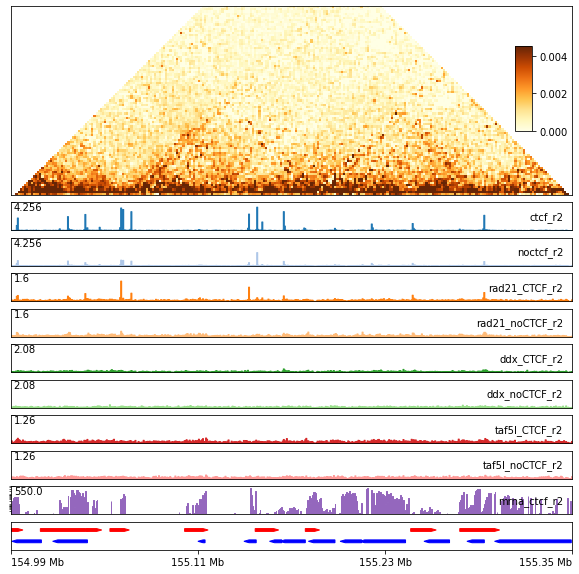

In [160]:
region = regions[2]
chrom, start, end = bioframe.parse_region_string(region)
print(f"original length of the region {region} is {int((end - start)/1000)}kb")
start -= 150_000
end += 150_000

binsize = 2000
clr = cooler.Cooler(f"""{ins_samples["CkoCT442_NT_pool.hg19"]}::/resolutions/{binsize}""")
mat = clr.matrix().fetch((chrom,start,end))
clr_width, = np.diff(clr.extent((chrom,start,end)))
# ignore 2 diagonals ...
for diag in [-1,0,1]:
    mat = numutils.set_diag(mat, np.nan, diag, copy=True)

fig_samples = ["ctcf_r2","noctcf_r2","rad21_CTCF_r2","rad21_noCTCF_r2","ddx_CTCF_r2","ddx_noCTCF_r2","taf5l_CTCF_r2","taf5l_noCTCF_r2","mrna_ctcf_r2"]
vecs = {}
for s in fig_samples:
    print(f"pulling {s} ...")
    v = bbi.fetch(
        samples[s]["fname"],
        chrom=chrom,
        start=start,
        end=end,
        bins=3*clr_width,
        missing=0.0,
        oob=np.nan,
        summary='mean',
    )
    vecs[s] = v

genp = bbi.fetch(
    "gene_plus.bb",
    chrom=chrom,
    start=start,
    end=end,
    bins=3*clr_width,
    missing=0.0,
    oob=np.nan,
    summary='mean',
)

genm = bbi.fetch(
    "gene_minus.bb",
    chrom=chrom,
    start=start,
    end=end,
    bins=3*clr_width,
    missing=0.0,
    oob=np.nan,
    summary='mean',
)

f,ax = plt.subplots(figsize=(20,10))

matt = ax.imshow(
    rotate_hm(mat),
    norm=colors.Normalize(vmin=0.0000,vmax=0.0045),
#     norm=colors.LogNorm(vmin=0.0001,vmax=0.008),
    cmap="YlOrBr",
    interpolation="none",
)
ax.set_xticks([])
ax.set_yticks([])
cbaxes = inset_axes(ax, width="3%", height="45%", loc="upper right", borderpad=4)
cbaxes.tick_params(axis="y",direction="out")
plt.colorbar(matt, cax=cbaxes, orientation='vertical')



divider = make_axes_locatable(ax)

wtid=0 # a counter for the color of the chip-tracks
cmap = plt.cm.tab20 # color set ...
for s,track in vecs.items():
    cax = divider.append_axes("bottom", size="15%", pad=0.1)
    cax.set_xlim(0,3*clr_width)
    if s in ["ctcf_r2","noctcf_r2"]:
        s_color="tab:blue"
        s_color=cmap(0 + (wtid%2)/20.)
    elif s in ["rad21_CTCF_r2","rad21_noCTCF_r2"]:
        s_color="tab:red"
        s_color=cmap(1/10. + (wtid%2)/20.)
    elif s in ["ddx_CTCF_r2","ddx_noCTCF_r2"]:
        s_color="tab:cyan"
        s_color=cmap(2/10. + (wtid%2)/20.)
    elif s in ["taf5l_CTCF_r2","taf5l_noCTCF_r2"]:
        s_color="tab:olive"
        s_color=cmap(3/10. + (wtid%2)/20.)
    elif s in ["mrna_ctcf_r2",]:
        s_color="green"
        s_color=cmap(4/10. + (wtid%2)/20.)
    else:
        cax.set_ylim(ymin, ymax)
    wtid += 1
    if s in ["mrna_ctcf_r2",]:
        cax.fill_between(x=np.arange(len(track)), y1=track, y2=1, where=(track>=1.0), step="post",label=s, color=s_color)
    else:
        cax.fill_between(x=np.arange(len(track)), y1=track, y2=0, step="post",label=s, color=s_color)
    cax.set_xticks([])
    leg = cax.legend(frameon=False, handlelength=0.0,handletextpad=-2.0)
    for item in leg.legendHandles:
        item.set_visible(False)
    ymin, ymax = samples[s]["crange"]
    # control limits manually on track to track basis:
    if s in ["ctcf_r2","noctcf_r2"]:
        ymax = 1.33*ymax
    elif s in ["rad21_CTCF_r2","rad21_noCTCF_r2"]:
        ymax = 4*ymax
    elif s in ["ddx_CTCF_r2","ddx_noCTCF_r2"]:
        ymax = 4*ymax
    elif s in ["taf5l_CTCF_r2","taf5l_noCTCF_r2"]:
        ymax = 6*ymax
    elif s in ["mrna_ctcf_r2",]:
        ymax = 25*ymax
    else:
        pass
    if samples[s]["norm"] is not None:
        cax.set_yscale("log")
        ymin = 1
    cax.set_ylim(ymin, ymax)
    cax.set_yticks([ymax])
    cax.set_yticklabels([ymax], va='top', ha="left",minor=False)
    cax.tick_params(axis="y",direction="in",pad=-3)    
print(cax.get_ylim())

cax = divider.append_axes("bottom", size="15%", pad=0.1)
cax.set_xlim(0,3*clr_width)


for s,e in zip(*gene_track_to_intervals(genp)):
    if e-s>1:
        cax.arrow(s,1+.1,e-s,0,width=0.05, head_width=0.05, head_length=5, edgecolor="none",color="red");
for s,e in zip(*gene_track_to_intervals(genm)):
    if e-s>1:
        cax.arrow(e,1-.1,s-e,0,width=0.05, head_width=0.05, head_length=5, edgecolor="none",color="blue");
cax.set_ylim(1-0.25,1+0.25)
cax.set_yticks([])


xticks = np.linspace(0,3*clr_width,4)
cax.set_xticks(xticks)

def nice_bp(bp):
    if bp > 1_000_000:
        return f"{(bp/1_000_000):.2f} Mb"
    elif bp > 1_000:
        return f"{(bp/1_000):.2f} kb"
    else:
        return f"{int(bp)} b"


cax.set_xticklabels(
    [
        nice_bp((clr.offset((chrom,start,end)) + (xt/3.0))*clr.binsize) for xt in xticks
    ],
    ha="left",
)

for ii,label in enumerate(cax.xaxis.get_majorticklabels()):
    if ii==0:
        label.set_ha("left")
    elif ii<3:
        label.set_ha("center")
    else:
        label.set_ha("right")

plt.savefig(f"latest_greates1_r2.pdf")


original length of the region chr1:153,563,139-153,762,287 is 199kb
pulling ctcf_r2 ...
pulling noctcf_r2 ...
pulling rad21_CTCF_r2 ...
pulling rad21_noCTCF_r2 ...
pulling ddx_CTCF_r2 ...
pulling ddx_noCTCF_r2 ...
pulling taf5l_CTCF_r2 ...
pulling taf5l_noCTCF_r2 ...
pulling mrna_ctcf_r2 ...
(1.0, 1320.0)


/tmp/ipykernel_30115/1264966523.py:130: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  cax.arrow(s,1+.1,e-s,0,width=0.05, head_width=0.05, head_length=5, edgecolor="none",color="red");
/tmp/ipykernel_30115/1264966523.py:133: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  cax.arrow(e,1-.1,s-e,0,width=0.05, head_width=0.05, head_length=5, edgecolor="none",color="blue");
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 32 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.nu

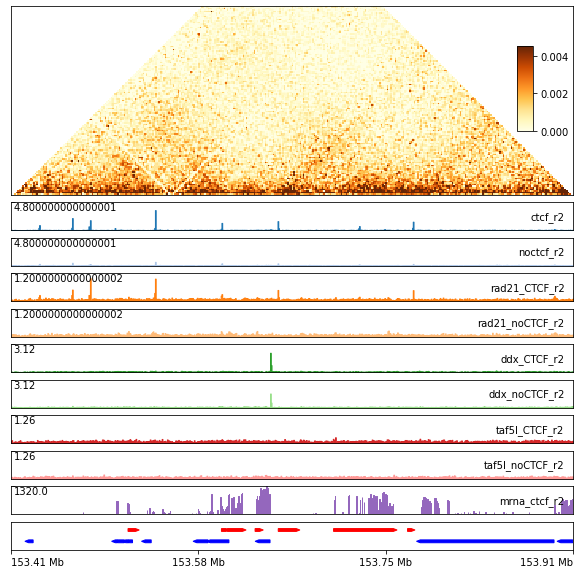

In [161]:
region = regions[5]

chrom, start, end = bioframe.parse_region_string(region)
print(f"original length of the region {region} is {int((end - start)/1000)}kb")
start -= 150_000
end += 150_000

binsize = 2000
clr = cooler.Cooler(f"""{ins_samples["CkoCT442_NT_pool.hg19"]}::/resolutions/{binsize}""")
mat = clr.matrix().fetch((chrom,start,end))
clr_width, = np.diff(clr.extent((chrom,start,end)))
# ignore 2 diagonals ...
for diag in [-1,0,1]:
    mat = numutils.set_diag(mat, np.nan, diag, copy=True)

fig_samples = ["ctcf_r2","noctcf_r2","rad21_CTCF_r2","rad21_noCTCF_r2","ddx_CTCF_r2","ddx_noCTCF_r2","taf5l_CTCF_r2","taf5l_noCTCF_r2","mrna_ctcf_r2"]
vecs = {}
for s in fig_samples:
    print(f"pulling {s} ...")
    v = bbi.fetch(
        samples[s]["fname"],
        chrom=chrom,
        start=start,
        end=end,
        bins=3*clr_width,
        missing=0.0,
        oob=np.nan,
        summary='mean',
    )
    vecs[s] = v

genp = bbi.fetch(
    "gene_plus.bb",
    chrom=chrom,
    start=start,
    end=end,
    bins=3*clr_width,
    missing=0.0,
    oob=np.nan,
    summary='mean',
)

genm = bbi.fetch(
    "gene_minus.bb",
    chrom=chrom,
    start=start,
    end=end,
    bins=3*clr_width,
    missing=0.0,
    oob=np.nan,
    summary='mean',
)

f,ax = plt.subplots(figsize=(19,10))

matt = ax.imshow(
    rotate_hm(mat),
    norm=colors.Normalize(vmin=0.0000,vmax=0.0045),
#     norm=colors.LogNorm(vmin=0.0001,vmax=0.008),
    cmap="YlOrBr",
    interpolation="none",
)
ax.set_xticks([])
ax.set_yticks([])
cbaxes = inset_axes(ax, width="3%", height="45%", loc="upper right", borderpad=4)
cbaxes.tick_params(axis="y",direction="out")
plt.colorbar(matt, cax=cbaxes, orientation='vertical')

divider = make_axes_locatable(ax)

wtid=0 # a counter for the color of the chip-tracks
cmap = plt.cm.tab20 # color set ...
for s,track in vecs.items():
    cax = divider.append_axes("bottom", size="15%", pad=0.1)
    cax.set_xlim(0,3*clr_width)
    if s in ["ctcf_r2","noctcf_r2"]:
        s_color="tab:blue"
        s_color=cmap(0 + (wtid%2)/20.)
    elif s in ["rad21_CTCF_r2","rad21_noCTCF_r2"]:
        s_color="tab:red"
        s_color=cmap(1/10. + (wtid%2)/20.)
    elif s in ["ddx_CTCF_r2","ddx_noCTCF_r2"]:
        s_color="tab:cyan"
        s_color=cmap(2/10. + (wtid%2)/20.)
    elif s in ["taf5l_CTCF_r2","taf5l_noCTCF_r2"]:
        s_color="tab:olive"
        s_color=cmap(3/10. + (wtid%2)/20.)
    elif s in ["mrna_ctcf_r2",]:
        s_color="green"
        s_color=cmap(4/10. + (wtid%2)/20.)
    else:
        cax.set_ylim(ymin, ymax)
    wtid += 1
    if s in ["mrna_ctcf_r2",]:
        cax.fill_between(x=np.arange(len(track)), y1=track, y2=1, where=(track>=1.0), step="post",label=s, color=s_color)
    else:
        cax.fill_between(x=np.arange(len(track)), y1=track, y2=0, step="post",label=s, color=s_color)
    cax.set_xticks([])
    leg = cax.legend(frameon=False, handlelength=0.0,handletextpad=-2.0)
    for item in leg.legendHandles:
        item.set_visible(False)
    ymin, ymax = samples[s]["crange"]
    # control limits manually on track to track basis:
    if s in ["ctcf_r2","noctcf_r2"]:
        ymax = 1.5*ymax
    elif s in ["rad21_CTCF_r2","rad21_noCTCF_r2"]:
        ymax = 3*ymax
    elif s in ["ddx_CTCF_r2","ddx_noCTCF_r2"]:
        ymax = 6*ymax
    elif s in ["taf5l_CTCF_r2","taf5l_noCTCF_r2"]:
        ymax = 6*ymax
    elif s in ["mrna_ctcf_r2",]:
        ymax = 60*ymax
    else:
        pass
    if samples[s]["norm"] is not None:
        cax.set_yscale("log")
        ymin = 1
    cax.set_ylim(ymin, ymax)
    cax.set_yticks([ymax])
    cax.set_yticklabels([ymax], va='top', ha="left",minor=False)
    cax.tick_params(axis="y",direction="in",pad=-3)    
print(cax.get_ylim())

cax = divider.append_axes("bottom", size="15%", pad=0.1)
cax.set_xlim(0,3*clr_width)

for s,e in zip(*gene_track_to_intervals(genp)):
    if e-s>1:
        cax.arrow(s,1+.1,e-s,0,width=0.05, head_width=0.05, head_length=5, edgecolor="none",color="red");
for s,e in zip(*gene_track_to_intervals(genm)):
    if e-s>1:
        cax.arrow(e,1-.1,s-e,0,width=0.05, head_width=0.05, head_length=5, edgecolor="none",color="blue");
cax.set_ylim(1-0.25,1+0.25)
cax.set_yticks([])


xticks = np.linspace(0,3*clr_width,4)
cax.set_xticks(xticks)

def nice_bp(bp):
    if bp > 1_000_000:
        return f"{(bp/1_000_000):.2f} Mb"
    elif bp > 1_000:
        return f"{(bp/1_000):.2f} kb"
    else:
        return f"{int(bp)} b"


cax.set_xticklabels(
    [
        nice_bp((clr.offset((chrom,start,end)) + (xt/3.0))*clr.binsize) for xt in xticks
    ],
    ha="left",
)

for ii,label in enumerate(cax.xaxis.get_majorticklabels()):
    if ii==0:
        label.set_ha("left")
    elif ii<3:
        label.set_ha("center")
    else:
        label.set_ha("right")

plt.savefig(f"latest_greates2_r2.pdf")


original length of the region chr1:163,259,163-163,334,271 is 75kb
pulling ctcf_r2 ...
pulling noctcf_r2 ...
pulling rad21_CTCF_r2 ...
pulling rad21_noCTCF_r2 ...
pulling ddx_CTCF_r2 ...
pulling ddx_noCTCF_r2 ...
pulling taf5l_CTCF_r2 ...
pulling taf5l_noCTCF_r2 ...
pulling mrna_ctcf_r2 ...
(1.0, 550.0)


/tmp/ipykernel_30115/3282511231.py:130: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  cax.arrow(s,1+.1,e-s,0,width=0.05, head_width=0.05, head_length=5, edgecolor="none",color="red");
/tmp/ipykernel_30115/3282511231.py:133: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  cax.arrow(e,1-.1,s-e,0,width=0.05, head_width=0.05, head_length=5, edgecolor="none",color="blue");
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 31 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.nu

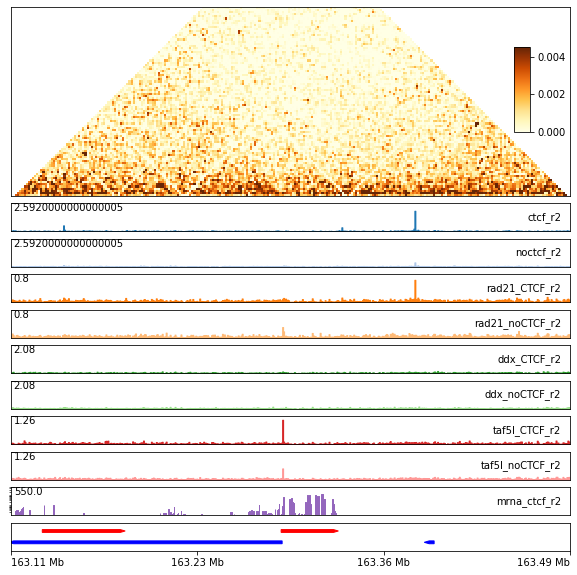

In [162]:
region = regions[10]

chrom, start, end = bioframe.parse_region_string(region)
print(f"original length of the region {region} is {int((end - start)/1000)}kb")
start -= 150_000
end += 150_000

binsize = 2000
clr = cooler.Cooler(f"""{ins_samples["CkoCT442_NT_pool.hg19"]}::/resolutions/{binsize}""")
mat = clr.matrix().fetch((chrom,start,end))
clr_width, = np.diff(clr.extent((chrom,start,end)))
# ignore 2 diagonals ...
for diag in [-1,0,1]:
    mat = numutils.set_diag(mat, np.nan, diag, copy=True)

fig_samples = ["ctcf_r2","noctcf_r2","rad21_CTCF_r2","rad21_noCTCF_r2","ddx_CTCF_r2","ddx_noCTCF_r2","taf5l_CTCF_r2","taf5l_noCTCF_r2","mrna_ctcf_r2"]
vecs = {}
for s in fig_samples:
    print(f"pulling {s} ...")
    v = bbi.fetch(
        samples[s]["fname"],
        chrom=chrom,
        start=start,
        end=end,
        bins=3*clr_width,
        missing=0.0,
        oob=np.nan,
        summary='mean',
    )
    vecs[s] = v

genp = bbi.fetch(
    "gene_plus.bb",
    chrom=chrom,
    start=start,
    end=end,
    bins=3*clr_width,
    missing=0.0,
    oob=np.nan,
    summary='mean',
)

genm = bbi.fetch(
    "gene_minus.bb",
    chrom=chrom,
    start=start,
    end=end,
    bins=3*clr_width,
    missing=0.0,
    oob=np.nan,
    summary='mean',
)

f,ax = plt.subplots(figsize=(19,10))

matt = ax.imshow(
    rotate_hm(mat),
    norm=colors.Normalize(vmin=0.0000,vmax=0.0045),
#     norm=colors.LogNorm(vmin=0.0001,vmax=0.008),
    cmap="YlOrBr",
    interpolation="none",
)
ax.set_xticks([])
ax.set_yticks([])
cbaxes = inset_axes(ax, width="3%", height="45%", loc="upper right", borderpad=4)
cbaxes.tick_params(axis="y",direction="out")
plt.colorbar(matt, cax=cbaxes, orientation='vertical')

divider = make_axes_locatable(ax)

wtid=0 # a counter for the color of the chip-tracks
cmap = plt.cm.tab20 # color set ...
for s,track in vecs.items():
    cax = divider.append_axes("bottom", size="15%", pad=0.1)
    cax.set_xlim(0,3*clr_width)
    if s in ["ctcf_r2","noctcf_r2"]:
        s_color="tab:blue"
        s_color=cmap(0 + (wtid%2)/20.)
    elif s in ["rad21_CTCF_r2","rad21_noCTCF_r2"]:
        s_color="tab:red"
        s_color=cmap(1/10. + (wtid%2)/20.)
    elif s in ["ddx_CTCF_r2","ddx_noCTCF_r2"]:
        s_color="tab:cyan"
        s_color=cmap(2/10. + (wtid%2)/20.)
    elif s in ["taf5l_CTCF_r2","taf5l_noCTCF_r2"]:
        s_color="tab:olive"
        s_color=cmap(3/10. + (wtid%2)/20.)
    elif s in ["mrna_ctcf_r2",]:
        s_color="green"
        s_color=cmap(4/10. + (wtid%2)/20.)
    else:
        cax.set_ylim(ymin, ymax)
    wtid += 1
    if s in ["mrna_ctcf_r2",]:
        cax.fill_between(x=np.arange(len(track)), y1=track, y2=1, where=(track>=1.0), step="post",label=s, color=s_color)
    else:
        cax.fill_between(x=np.arange(len(track)), y1=track, y2=0, step="post",label=s, color=s_color)
    cax.set_xticks([])
    leg = cax.legend(frameon=False, handlelength=0.0,handletextpad=-2.0)
    for item in leg.legendHandles:
        item.set_visible(False)
    ymin, ymax = samples[s]["crange"]
    # control limits manually on track to track basis:
    if s in ["ctcf_r2","noctcf_r2"]:
        ymax = 0.81*ymax
    elif s in ["rad21_CTCF_r2","rad21_noCTCF_r2"]:
        ymax = 2*ymax
    elif s in ["ddx_CTCF_r2","ddx_noCTCF_r2"]:
        ymax = 4*ymax
    elif s in ["taf5l_CTCF_r2","taf5l_noCTCF_r2"]:
        ymax = 6*ymax
    elif s in ["mrna_ctcf_r2",]:
        ymax = 25*ymax
    else:
        pass
    if samples[s]["norm"] is not None:
        cax.set_yscale("log")
        ymin = 1
    cax.set_ylim(ymin, ymax)
    cax.set_yticks([ymax])
    cax.set_yticklabels([ymax], va='top', ha="left",minor=False)
    cax.tick_params(axis="y",direction="in",pad=-3)    
print(cax.get_ylim())

cax = divider.append_axes("bottom", size="15%", pad=0.1)
cax.set_xlim(0,3*clr_width)

for s,e in zip(*gene_track_to_intervals(genp)):
    if e-s>1:
        cax.arrow(s,1+.1,e-s,0,width=0.05, head_width=0.05, head_length=5, edgecolor="none",color="red");
for s,e in zip(*gene_track_to_intervals(genm)):
    if e-s>1:
        cax.arrow(e,1-.1,s-e,0,width=0.05, head_width=0.05, head_length=5, edgecolor="none",color="blue");
cax.set_ylim(1-0.25,1+0.25)
cax.set_yticks([])


xticks = np.linspace(0,3*clr_width,4)
cax.set_xticks(xticks)

def nice_bp(bp):
    if bp > 1_000_000:
        return f"{(bp/1_000_000):.2f} Mb"
    elif bp > 1_000:
        return f"{(bp/1_000):.2f} kb"
    else:
        return f"{int(bp)} b"


cax.set_xticklabels(
    [
        nice_bp((clr.offset((chrom,start,end)) + (xt/3.0))*clr.binsize) for xt in xticks
    ]
)

for ii,label in enumerate(cax.xaxis.get_majorticklabels()):
    if ii==0:
        label.set_ha("left")
    elif ii<3:
        label.set_ha("center")
    else:
        label.set_ha("right")

plt.savefig(f"latest_greates3_r2.pdf")


In [163]:
! scp latest_greates1_r2.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
! scp latest_greates2_r2.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
! scp latest_greates3_r2.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

latest_greates1_r2.pdf                        100%  122KB   2.4MB/s   00:00    
latest_greates2_r2.pdf                        100%  178KB 981.2KB/s   00:00    
latest_greates3_r2.pdf                        100%  120KB   2.9MB/s   00:00    


In [254]:
# f,ax = plt.subplots(figsize=(19,10))
# extent = [c*binsize for c in clr.extent(region)]

# ax.imshow(
#     rotate_hm(mat),
# #     norm=colors.Normalize(vmin=0.0001,vmax=0.003),
#     norm=colors.LogNorm(vmin=0.0001,vmax=0.008),
#     cmap="YlOrBr",
#     interpolation="none",
#     # extent=(*extent, *extent[::-1])
# )
# ax.set_xticks([])
# ax.set_yticks([])

# divider = make_axes_locatable(ax)

# for s,track in vecs.items():
#     cax = divider.append_axes("bottom", size="15%", pad=0.1)
#     cax.set_xlim(0,3*clr_width)
#     cax.fill_between(x=np.arange(len(track)), y1=track, y2=0, step="post")
#     cax.set_xticks([])
#     if samples[s]["norm"] is not None:
#         cax.set_yscale("log")
#     ymin,ymax = samples[s]["crange"]
#     cax.set_ylim(ymin, ymax)
    
# cax = divider.append_axes("bottom", size="15%", pad=0.1)
# cax.set_xlim(0,3*clr_width)

# for s,e in zip(*gene_track_to_intervals(genp)):
#     if e-s>1:
#         cax.arrow(s,1+.1,e-s,0,width=0.05, head_width=0.05, head_length=5, edgecolor="none",color="red")
# for s,e in zip(*gene_track_to_intervals(genm)):
#     if e-s>1:
#         cax.arrow(e,1-.1,s-e,0,width=0.05, head_width=0.05, head_length=5, edgecolor="none",color="blue")
# cax.set_ylim(1-0.25,1+0.25)

# # cax.plot(genp)
# format_ticks(cax, x=True, y=False, rotate=False)

# # cax = divider.append_axes("bottom", size="15%", pad=0.1)
# # cax.set_xlim(0,2*clr_width)
# # cax.plot(genm)

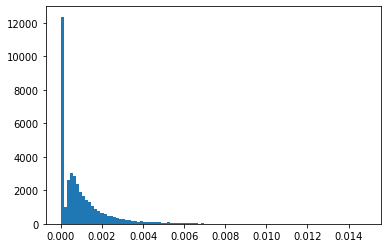

In [69]:
plt.hist(mat.flatten(),bins=100);

In [78]:
chrom="chr1"
start=153_305_956
end=153_705_104
bbi.fetch(
    fname = samples["ins_CTCF_500M"]["fname"],
    chrom,
    start,
    end,
    bins=3000,
    missing=0.0,
    oob=np.nan,
    summary='mean',
)

In [ ]:
# key features/signals that we want to extract for our genes ...
key_features  = [
                "ins_noTIR1_500M",  # 500M reads to make em equally-deep
                "ins_CTCF_500M",  # 500M reads to make em equally-deep
                "ins_noCTCF_500M",  # 500M reads to make em equally-deep
                "ins_WT_combined",  # ~800M
                "ins_polII_800M",  # 800M to make it match  ins_WT_combined
                "ins_nopolII_800M",  # 800M to make it match  ins_WT_combined
                "ins_rad21",
                "ins_norad21",
                "ins_waplWT",
                "ins_waplKO1",
                "ins_waplKO3",
                "Rloop_K562",
                "rad21_CTCF",
                "rad21_noCTCF",
                "rad21_wt1",
                "rad21_rad21",
                "rad21_norad21",
                "newrad21_PolII",
                "newrad21_noPolII",
                ]

profiles_dict = {}

# group genes by expression and size before extracting corresponding profiles of a list of features :
gene_groups = gdf.groupby(["status","gsize"])
for feature_name in key_features:
    print(f"extracting {feature_name} for the genes ...")
    feature_fname = samples[feature_name]["fname"]
    profiles_dict[feature_name] = gene_groups.apply( lambda sub_df: extract_ins(sub_df, feature_fname) )

In [8]:
# # checking sequencing depth of several samples ...
# !cooler info all_combined.mcool::/resolutions/25000 | grep sum
# !cooler info all_combined.mcool::/resolutions/25000 | grep nnz
# !cooler info noCTCF_IAA_combined.mcool::/resolutions/25000 | grep sum
# !cooler info noCTCF_IAA_combined.mcool::/resolutions/25000 | grep nnz

In [11]:
Rectangle?

In [9]:
# Rectangle(xy, width, height, angle=0.0, **kwargs)

In [21]:
www  = np.array([10,7,4,4,2])

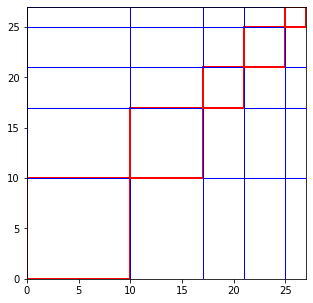

In [26]:
from matplotlib.patches import Rectangle

#define Matplotlib figure and axis
fig, ax = plt.subplots(figsize=(5,5))
ax.set_xlim(0,www.sum())
ax.set_ylim(0,www.sum())

# #create simple line plot
# ax.plot([0, 10],[0, 10])


y = 0
for wy in www:
    x = 0
    for wx in www:
        #add rectangle to plot
        c = "red" if x==y else "blue"
        lw = 2 if x==y else 1
        rect = Rectangle((x, y), wx, wy, fill=False, color=c, lw=lw)
        ax.add_patch(rect)
        x += wx
    y += wy
        



# x,y = 0,0
# for w in www:
#     #add rectangle to plot
#     rect = Rectangle((x, y), w, w, fill=False, color="blue")
#     ax.add_patch(rect)
#     x += w
#     y += w
